In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
trash_df = pd.read_csv("data/생활폐기물_변화량.csv")
trash_df.tail()

,시점,매립,소각,재활용
18,2014,6271.7,11530.6,24552.9
19,2015,5953.2,12074.9,25383.1
20,2016,6465.5,12389.0,26605.8
21,2017,6229.1,12016.7,26763.1
22,2018,6545.2,12429.3,27774.8


In [3]:
trash_df['총배출량'] = trash_df['매립'] + trash_df['소각'] + trash_df['재활용']
trash_df.columns = ['year','landfill','incineration', 'recycling', 'all_trash']
display(trash_df)

,year,landfill,incineration,recycling,all_trash
0,1996,29066.0,2148.9,11008.2,42223.1
1,1997,25986.4,2684.2,11659.8,40330.4
2,1998,21825.6,3310.9,13028.7,38165.2
3,1999,20402.4,3936.5,14330.1,38669.0
4,2000,18956.3,4730.7,15697.2,39384.2
5,2001,17557.5,5908.5,17302.2,40768.2
6,2002,17508.0,6619.1,18655.8,42782.9
7,2003,17205.8,6761.6,18950.7,42918.1
8,2004,14954.6,6524.4,20099.0,41578.0
9,2005,11139.4,6933.7,22493.4,40566.5


## 매립량 시계열 분석

In [4]:
all_trash_df = trash_df.iloc[:,[0,1]]
all_trash_df.set_index('year', inplace=True)
train_df = all_trash_df.iloc[0:21]
test_df = all_trash_df.iloc[21:23]
display(train_df)
display(test_df)

,landfill
year,
1996,29066.0
1997,25986.4
1998,21825.6
1999,20402.4
2000,18956.3
2001,17557.5
2002,17508.0
2003,17205.8
2004,14954.6


,landfill
year,
2017,6229.1
2018,6545.2


In [5]:
train_df.describe()

,landfill
count,21.000000
mean,13125.647619
std,7176.363156
min,5953.200000
25%,6684.300000
50%,10334.000000
75%,17557.500000
max,29066.000000


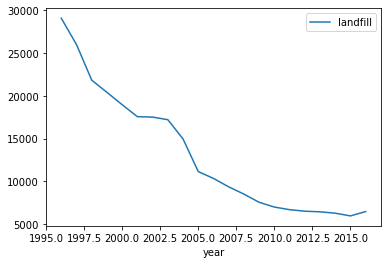

In [6]:
train_df.plot()
plt.show()

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_df.landfill.values, order=(2,1,2))
model_fit = model.fit(trend='nc', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -168.378
Method:                       css-mle   S.D. of innovations           1060.890
Date:                Fri, 18 Dec 2020   AIC                            346.756
Time:                        14:41:43   BIC                            351.735
Sample:                             1   HQIC                           347.728
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.8880      0.594      1.494      0.135      -0.277       2.053
ar.L2.D.y      0.0727      0.567      0.128      0.898      -1.039       1.184
ma.L1.D.y     -0.2111      0.552     -0.383      0.7

<AxesSubplot:>

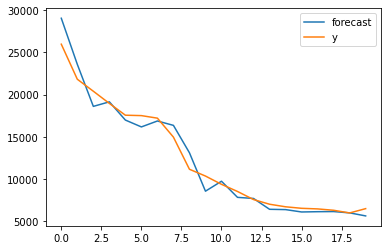

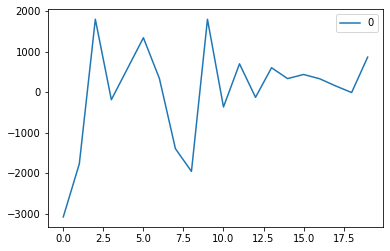

In [8]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

In [9]:
forecast_data = model_fit.forecast(steps=2) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = test_df.landfill.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

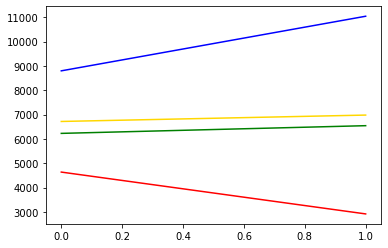

In [10]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

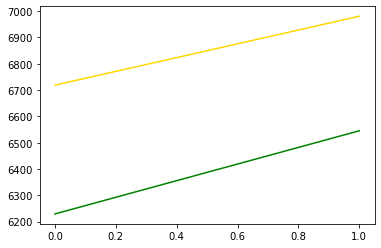

In [11]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

463.33860452190146


In [13]:
display(forecast_data[0])

array([6718.67816295, 6980.72100666])

In [14]:
display(test_df)

,landfill
year,
2017,6229.1
2018,6545.2


In [15]:
landfill_predict_data = model_fit.forecast(steps=20) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

In [16]:
display(landfill_predict_data[0])

array([6718.67816295, 6646.78287667, 6601.3414554 , 6555.76635624,
       6511.9950118 , 6469.81562108, 6429.18090965, 6390.03350755,
       6352.3190368 , 6315.98504257, 6280.98099512, 6247.25821388,
       6214.76980019, 6183.47057202, 6153.31700119, 6124.26715276,
       6096.28062678, 6069.31850205, 6043.34328203, 6018.31884269])

In [23]:
display(landfill_predict_data[0][2:21])

array([6601.3414554 , 6555.76635624, 6511.9950118 , 6469.81562108,
       6429.18090965, 6390.03350755, 6352.3190368 , 6315.98504257,
       6280.98099512, 6247.25821388, 6214.76980019, 6183.47057202,
       6153.31700119, 6124.26715276, 6096.28062678, 6069.31850205,
       6043.34328203, 6018.31884269])

In [29]:
a = []
for i in range(2019, 2037):
    a.append(i)
    
add_df = pd.DataFrame(data={'year':a, 'landfill':landfill_predict_data[0][2:21]})
add_df.set_index('year', inplace=True) 
display(add_df)

,landfill
year,
2019,6601.341455
2020,6555.766356
2021,6511.995012
2022,6469.815621
2023,6429.180910
2024,6390.033508
2025,6352.319037
2026,6315.985043
2027,6280.980995


In [31]:
landfill_pred_df = pd.concat([all_trash_df,add_df])
display(landfill_pred_df)

,landfill
year,
1996,29066.000000
1997,25986.400000
1998,21825.600000
1999,20402.400000
2000,18956.300000
2001,17557.500000
2002,17508.000000
2003,17205.800000
2004,14954.600000


## 소각량 시계열 분석

In [32]:
all_trash_df = trash_df.iloc[:,[0,2]]
all_trash_df.set_index('year', inplace=True)
train_df = all_trash_df.iloc[0:21]
test_df = all_trash_df.iloc[21:23]
display(train_df)
display(test_df)

,incineration
year,
1996,2148.9
1997,2684.2
1998,3310.9
1999,3936.5
2000,4730.7
2001,5908.5
2002,6619.1
2003,6761.6
2004,6524.4


,incineration
year,
2017,12016.7
2018,12429.3


In [33]:
train_df.describe()

,incineration
count,21.00000
mean,7708.40000
std,3165.07037
min,2148.90000
25%,5908.50000
50%,7500.70000
75%,10671.50000
max,12389.00000


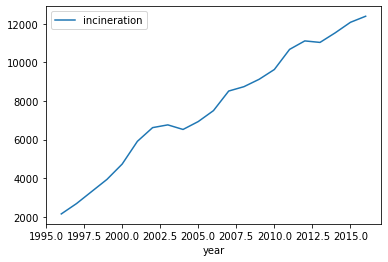

In [34]:
train_df.plot()
plt.show()

In [35]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_df.incineration.values, order=(1,1,1))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -143.927
Method:                       css-mle   S.D. of innovations            321.934
Date:                Fri, 18 Dec 2020   AIC                            295.854
Time:                        14:59:49   BIC                            299.837
Sample:                             1   HQIC                           296.632
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        508.9717     94.106      5.409      0.000     324.528     693.415
ar.L1.D.y     -0.0398      0.387     -0.103      0.918      -0.798       0.719
ma.L1.D.y      0.3744      0.314      1.191      0.2

<AxesSubplot:>

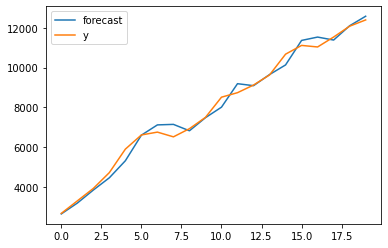

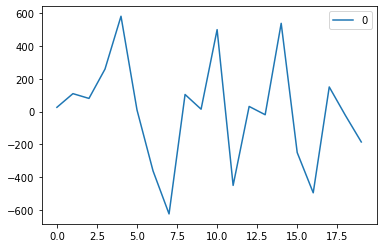

In [36]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

In [37]:
forecast_data = model_fit.forecast(steps=2) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = test_df.incineration.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

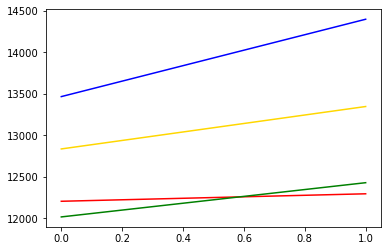

In [38]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

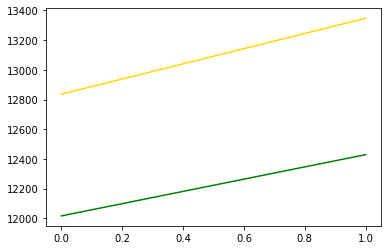

In [39]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [40]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

870.4310134119038


In [41]:
display(forecast_data[0])

array([12836.31601569, 13347.73883033])

In [42]:
display(test_df)

,incineration
year,
2017,12016.7
2018,12429.3


In [43]:
inc_predict_data = model_fit.forecast(steps=20) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

In [44]:
display(inc_predict_data[0])

array([12836.31601569, 13347.73883033, 13856.61307118, 14365.58863089,
       14874.56016267, 15383.53185457, 15892.50354011, 16401.4752259 ,
       16910.44691169, 17419.41859747, 17928.39028325, 18437.36196904,
       18946.33365482, 19455.3053406 , 19964.27702638, 20473.24871217,
       20982.22039795, 21491.19208373, 22000.16376952, 22509.1354553 ])

In [46]:
a = []
for i in range(2019, 2037):
    a.append(i)
    
add_df = pd.DataFrame(data={'year':a, 'incineration':inc_predict_data[0][2:21]})
add_df.set_index('year', inplace=True) 
display(add_df)

,incineration
year,
2019,13856.613071
2020,14365.588631
2021,14874.560163
2022,15383.531855
2023,15892.503540
2024,16401.475226
2025,16910.446912
2026,17419.418597
2027,17928.390283


In [47]:
inc_pred_df = pd.concat([all_trash_df,add_df])
display(inc_pred_df)

,incineration
year,
1996,2148.900000
1997,2684.200000
1998,3310.900000
1999,3936.500000
2000,4730.700000
2001,5908.500000
2002,6619.100000
2003,6761.600000
2004,6524.400000


# 재활용량 시계열 분석

In [49]:
all_trash_df = trash_df.iloc[:,[0,3]]
all_trash_df.set_index('year', inplace=True)
train_df = all_trash_df.iloc[0:21]
test_df = all_trash_df.iloc[21:23]
display(train_df)
display(test_df)

,recycling
year,
1996,11008.2
1997,11659.8
1998,13028.7
1999,14330.1
2000,15697.2
2001,17302.2
2002,18655.8
2003,18950.7
2004,20099.0


,recycling
year,
2017,26763.1
2018,27774.8


In [50]:
train_df.describe()

,recycling
count,21.000000
mean,20605.404762
std,4966.648446
min,11008.200000
25%,17302.200000
50%,22820.900000
75%,24552.900000
max,26605.800000


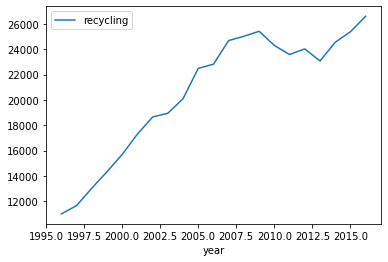

In [51]:
train_df.plot()
plt.show()

In [126]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_df.recycling.values, order=(2,1,1))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -162.873
Method:                       css-mle   S.D. of innovations            827.341
Date:                Fri, 18 Dec 2020   AIC                            335.745
Time:                        15:35:30   BIC                            340.724
Sample:                             1   HQIC                           336.717
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        807.8525    320.808      2.518      0.012     179.081    1436.624
ar.L1.D.y      0.1337      0.419      0.319      0.750      -0.688       0.955
ar.L2.D.y      0.3216      0.215      1.492      0.1

<AxesSubplot:>

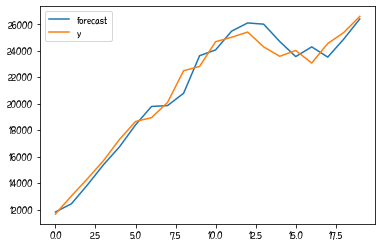

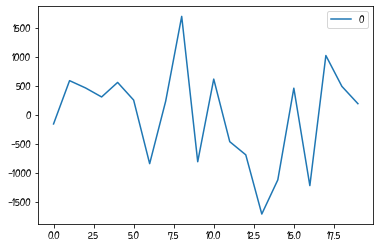

In [127]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

In [128]:
forecast_data = model_fit.forecast(steps=2) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = test_df.recycling.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

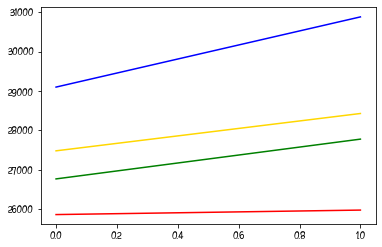

In [129]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

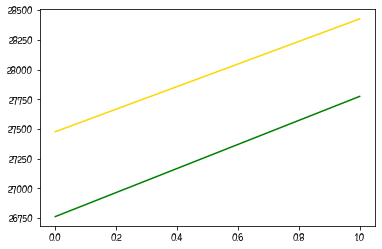

In [130]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [131]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

683.8665467840206


In [132]:
display(forecast_data[0])

array([27477.24017979, 28426.98916828])

In [133]:
display(test_df)

,recycling
year,
2017,26763.1
2018,27774.8


In [134]:
recycle_predict_data = model_fit.forecast(steps=20) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

In [135]:
display(recycle_predict_data[0])

array([27477.24017979, 28426.98916828, 29274.25938028, 30133.00896447,
       30960.34102489, 31787.16390787, 32603.81634426, 33418.94530658,
       34230.60025793, 35041.30087193, 35850.75681931, 36659.73949067,
       37468.25866177, 38276.56368188, 39084.69103138, 39892.72576634,
       40700.69098875, 41508.61713722, 42316.51570976, 43124.3980312 ])

In [136]:
a = []
for i in range(2019, 2037):
    a.append(i)
    
add_df = pd.DataFrame(data={'year':a, 'recycling':recycle_predict_data[0][2:21]})
add_df.set_index('year', inplace=True) 
display(add_df)

,recycling
year,
2019,29274.259380
2020,30133.008964
2021,30960.341025
2022,31787.163908
2023,32603.816344
2024,33418.945307
2025,34230.600258
2026,35041.300872
2027,35850.756819


In [137]:
recycle_pred_df = pd.concat([all_trash_df,add_df])
display(recycle_pred_df)

,recycling
year,
1996,11008.200000
1997,11659.800000
1998,13028.700000
1999,14330.100000
2000,15697.200000
2001,17302.200000
2002,18655.800000
2003,18950.700000
2004,20099.000000


In [138]:
t = landfill_pred_df.join(inc_pred_df)
result = t.join(recycle_pred_df)
result['total'] = result['landfill'] + result['incineration'] + result['recycling']
display(result)
result.to_csv("예측.csv")

,landfill,incineration,recycling,total
year,,,,
1996,29066.000000,2148.900000,11008.200000,42223.100000
1997,25986.400000,2684.200000,11659.800000,40330.400000
1998,21825.600000,3310.900000,13028.700000,38165.200000
1999,20402.400000,3936.500000,14330.100000,38669.000000
2000,18956.300000,4730.700000,15697.200000,39384.200000
2001,17557.500000,5908.500000,17302.200000,40768.200000
2002,17508.000000,6619.100000,18655.800000,42782.900000
2003,17205.800000,6761.600000,18950.700000,42918.100000
2004,14954.600000,6524.400000,20099.000000,41578.000000


In [139]:
from matplotlib import font_manager, rc
font_path = "../data/THEdog.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

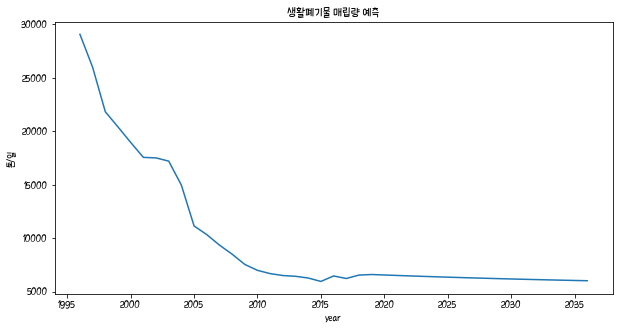

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

# 그래프 그리기
sns.lineplot(x=result.index , y="landfill",data=result,ax=ax1)
plt.title('생활폐기물 매립량 예측')
plt.ylabel('톤/일')
# 출력 
plt.savefig('생활폐기물 매립량 예측.png')
plt.show()

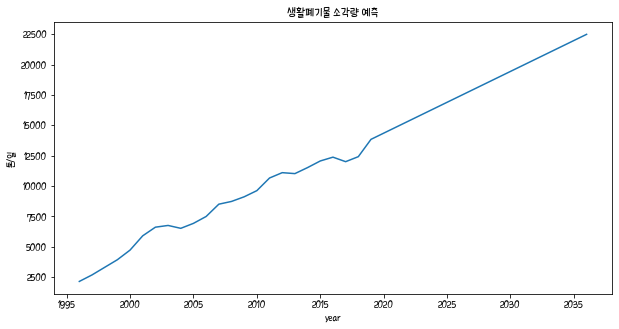

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

# 그래프 그리기
sns.lineplot(x=result.index , y="incineration",data=result,ax=ax1)
plt.title('생활폐기물 소각량 예측')
plt.ylabel('톤/일')
# 출력 
plt.savefig('생활폐기물 소각량 예측.png')
plt.show()

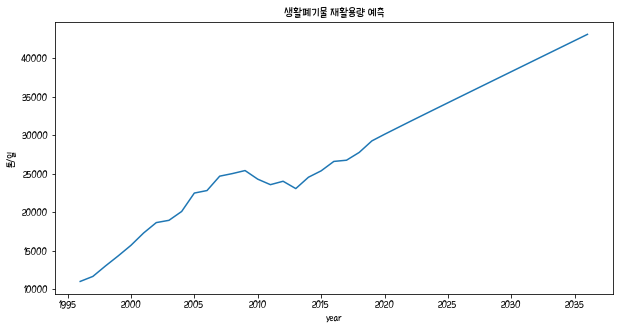

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

# 그래프 그리기
sns.lineplot(x=result.index , y="recycling",data=result,ax=ax1)
plt.title('생활폐기물 재활용량 예측')
plt.ylabel('톤/일')
plt.savefig('생활폐기물 재활용량 예측.png')
# 출력 
plt.show()

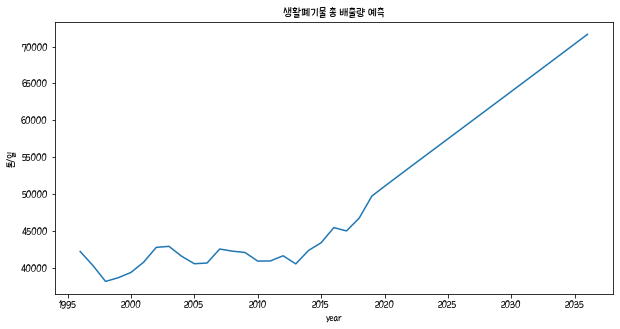

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

# 그래프 그리기
sns.lineplot(x=result.index , y="total",data=result,ax=ax1)
plt.title('생활폐기물 총 배출량 예측')
plt.ylabel('톤/일')
# 출력 
plt.savefig('생활폐기물 총 배출량 예측.png')
plt.show()